# Interne Abarbeitung von JOINS

Man unterscheidet bezüglicher der internen Abarbeitung (physical Join Operators) von Joins zwischen:

- Nested Loops
- Merge Join
- Hash Match

![](https://erhard-rainer.com/wp-content/uploads/2021/12/Types-of-Joines.png)

Exkurs: Auf der einen Seite gibt es logische Join Operationen, wie beispielsweise Inner-Join oder Left-Join; auf der anderen Seite gibt es physicalische Join Operatoren. Damit ist die interne Abarbeitung gemeint.

In Abhängigkeit der Verfügbarkeit von Indices werden die unterschiedlichen internen Verarbeitungsmethoden von Joins angewendet.

# Nested Loop Joins

![](https://erhard-rainer.com/wp-content/uploads/2021/12/image-23.png)

Beim Nested Loop Join wird jede Zeile der outer Table (in der Regel die kleinere Tabelle) mit der inner Table verglichen. Dieser Vorgang ist sehr speicherschonend (aber CPU lastig), aber skaliert sehr schlecht. Die Reihenfolge der Joins selbst spielt keine Rolle. Der Query Optimizer erkennt die kleinere Tabelle und macht sie zu "outer table". Die besten Ergebnisse erziehlt man, wenn die outer table recht kein ist und die inner table sehr groß und optimalerweise einen Index. Sofern ein brauchbarer Index gesetzt ist, kann man sich zusätzliche Zeit sparen, da man statt einem Table Scan oder Index Scan auf einen Index Seek zurückgreifen kann, der die Anzahl der gelesenen Rows dramatisch reduziert.

In [ ]:
SELECT cust.CustomerID, soh.SalesOrderID
	FROM Sales.Customer cust
		INNER JOIN Sales.SalesOrderHeader soh
			ON soh.CustomerID = cust.CustomerID
	WHERE cust.CustomerID = 11091

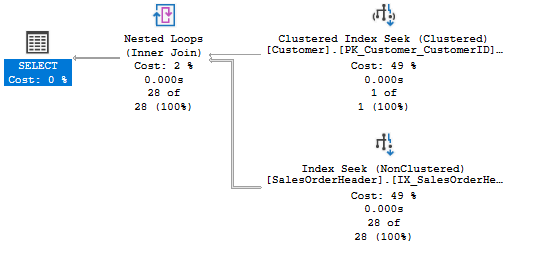

In [ ]:
Select COUNT(*) from Sales.Customer -- 19820 outer table 
Select COUNT(*) from Sales.SalesOrderHeader -- 31465 inner jable

Wieviel Lines müssen denn gelesen werden?

Outer Table ist gefiltert auf einen Datensatz. Aufgrund des Seek = 1 Zeile. 

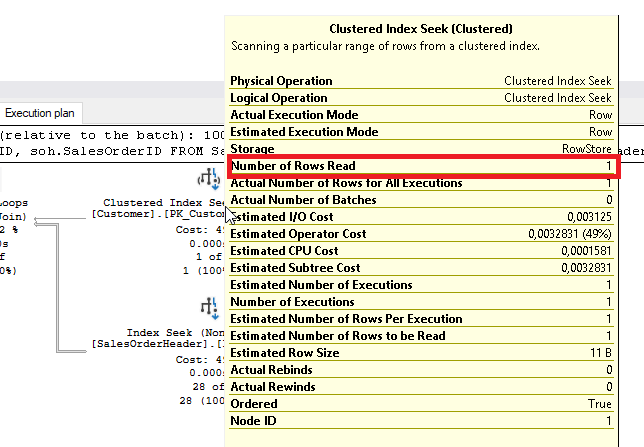  

Und 28 Zeilen vom Inner Table

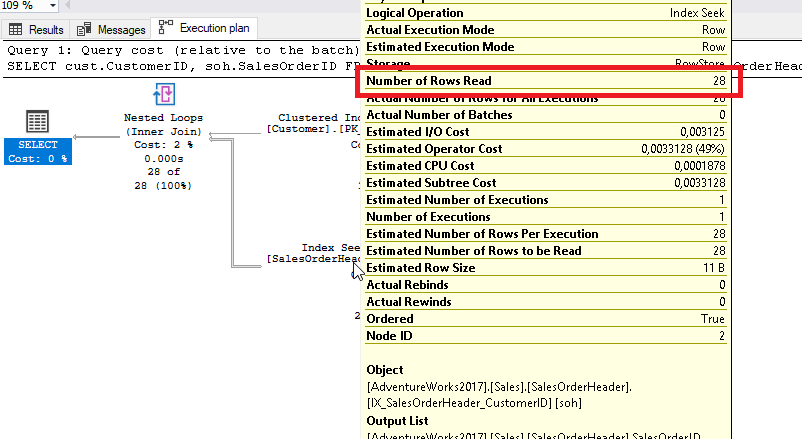  

Die Anzahl der Rows, die gelesen werden ist abhängig davon ob ein Table Scan, Index Scan oder Index Seek gemacht wird.

# Merge Join

Merge Join ist vermutlich der schnellste Join, da der Query Optimizier über jede Tabelle genau einmal iterieren muss. Voraussetzung ist aber, dass die Daten **<u>sortiert</u>** sind. Wenn man einen Merge Join vorfindet, besteht kein Optimierungspotential. Nur bei Tabellen mit bei denen bei beiden Tabellen Duplikate-Keys existieren, sind nicht so optimal.

In [ ]:
SELECT  P.Name, total_qty = SUM(I.Quantity)
	FROM Production.Product P
		JOIN Production.ProductInventory I  ON  I.ProductID = P.ProductID
	GROUP BY P.Name

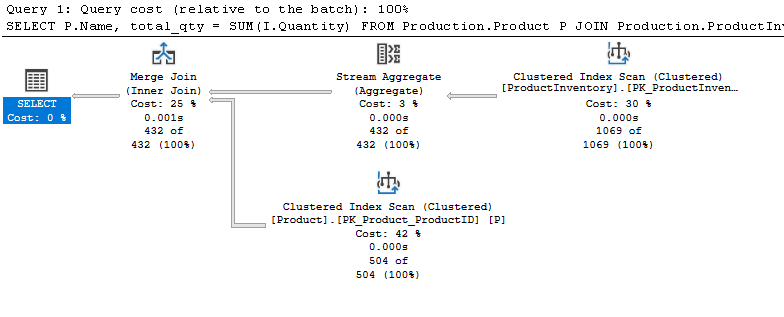

In diesem Fall haben wir 2 Clusted Index über die gejoint werden kann. 

In der Tabelle Product Inventory (1069 Zeilen) wird der Index komplett gelesen (Index Scan).

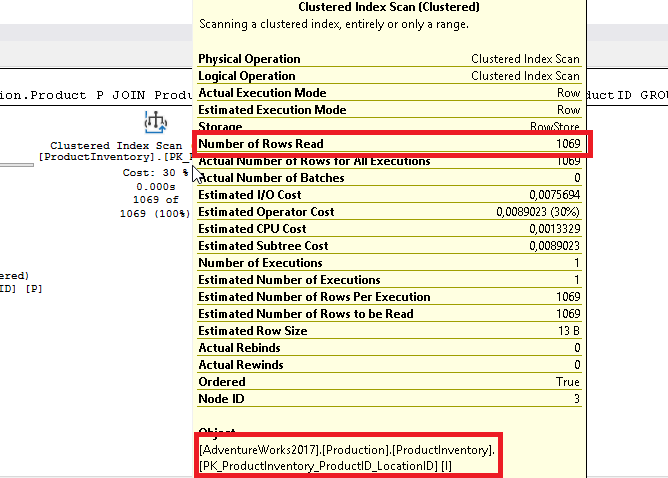

Selbiges bei der Tabelle Product.

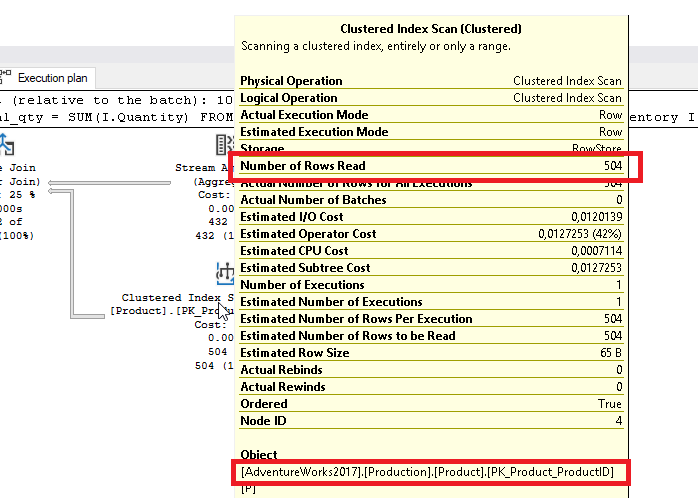

In [ ]:
	Select Count(*) from Production.ProductInventory --1069
	Select COUNT(*) from Production.Product --504

# Hash Match

Hash Match Inner Joins werden verwendet um große Tabellen, die nicht sortiert sind (über einen Index) zu verbinden. Sie berechnen für jeden Wert einen **<u>Hash-Value um sie miteinander zu vergleichen</u>**. Dabei verwendet der Algorithmus den Arbeitspeicher und sofern dieser nicht ausreicht auch die TempDB. Durch die mögliche Verwendung der TempDB kann die Abfrage langsam werden. Der Vorteil dieser Methode ist, dass die beiden Tabellen auch sehr groß sein können. Weiters handelt es sich beim Hash Match um einen Blocking Join - dh. solange der komplette Join nicht abgeschlossen ist, bekommt der User kein Ergebnis. Hash Match Join sollten in Transaktionsdatenbanken vermieden werden. In Analysedatenbanken haben sie ihre Berechtigung.

In [ ]:
SELECT p.Name As ProductName, ps.Name As ProductSubcategoryName
 FROM Production.Product p
 JOIN Production.ProductSubcategory ps
   ON p.ProductSubcategoryID = ps.ProductSubcategoryID
 ORDER BY p.Name,  ps.Name

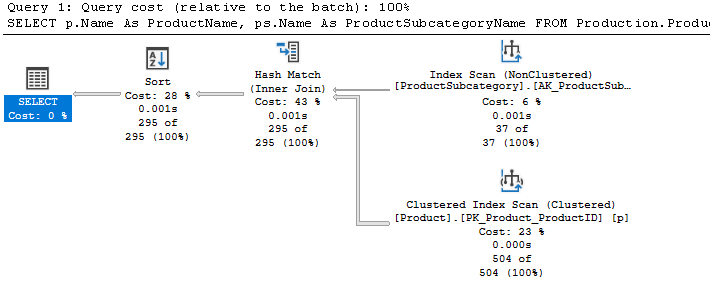

In [ ]:
 Select * from Production.ProductSubcategory --37
 Select * from Production.Product --504

# Erzwingen eines bestimmten Joins

Merge Join =\> Hash Join

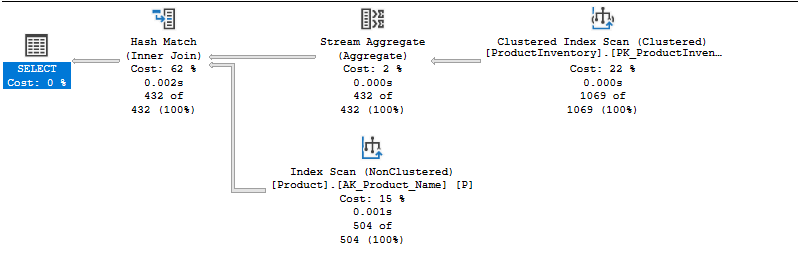

In [ ]:
SELECT  P.Name, total_qty = SUM(I.Quantity)
	FROM Production.Product P
		JOIN Production.ProductInventory I  ON  I.ProductID = P.ProductID 
		GROUP BY P.Name
		OPTION (HASH JOIN) 

Hash Match \> Merge Join

Da ein Merge Join sortierte Quellen benötigt, müssen an einer Stelle die Sortierung der Daten erfolgen.

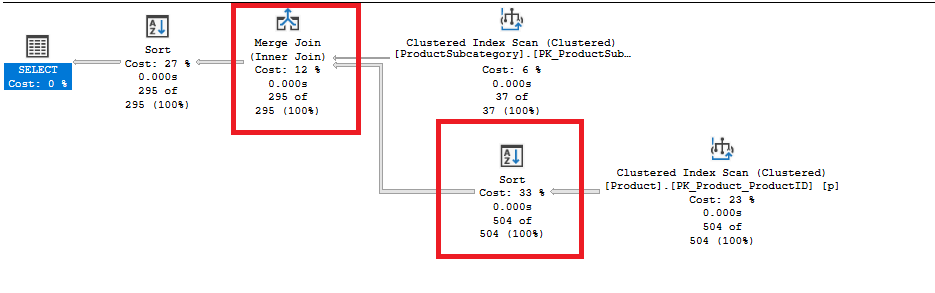

In [ ]:
SELECT p.Name As ProductName, ps.Name As ProductSubcategoryName
 FROM Production.Product p
 JOIN Production.ProductSubcategory ps
   ON p.ProductSubcategoryID = ps.ProductSubcategoryID
 ORDER BY p.Name,  ps.Name
 OPTION (MERGE JOIN)